## Colab Notebook created for ARAP module at UPC ETSETB.

Authors: Jaume Ros Alonso, Margarita Cabrera-Bean, Josep Vidal

**Martí Farré & Adriana Díaz**

## Deep Q-Learning

---



---



Deep Q-Learning builds on top of the previous Q-Learning. Instead of keeping an explicit table of action-states, we use a neural network to estimate the values of each action in a given state.

To update the network we compute a loss similar to what we did with Q-Learning: we compare value outputted from the network for the chosen action-state pair with the actual reward and the output for the next state.

However, there are a few nuances that we need to take into account to make training more stable:

### Experience replay

If we updated the network on every state, or using batches of consecutive states, these would be highly correlated, which is not desireable for training. To break these correlations we use a large FIFO queue, where we store all the data needed for computing the loss. Then, at every update step, we randomly sample this queue, which will be our uncorrelated batch.

### Target network

We use the network twice to compute the loss at every update: to estimate the values of the action at the given state and to estimate the value of the next state. However, this means that updates on the network can cause both ends of the loss function to change, leading to unstable updates.

A solution to this problem is using a separate network (`target_network`) that is used to estimate the latter part of the loss function (i.e. the value of the next state, taking the maximum of all state-action pairs). The target network will be frozen while the other one is being updated, and only after several iterations, we will copy the newer weights from the main network onto the target one.

### ASSIGNED TASKS
1.	Look at the code in detail and identify the parts where the behavioral or policy NN and the target NN are created. Run the code and observe the results obtained. Change the number of hidden layers and number of neurons of the critic and comment results.
2.	 The current method of updating the target network weights is the periodic one. Configure the smoothing method instead.
3.	Implement the Double Q-Learning strategy based on NN and explain the main modifications you have made. Use the Double QL proposed in https://arxiv.org/pdf/1509.06461.pdf (eq. 4)
4. Change the action function in class agent in order to use a softmax policy instead of the $\epsilon$-greedy one.
5.	Change the environment: size, initial state, final state, special states, Cliff states and check the behaviour of the DQN in the new environment.

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import deque

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Environment class

The environment class is what we'll use to define the environment. It is the same as always.

The most important function is `step`, which is what the Agent will use to interact with it.

In [ ]:
class Environment:

  # Define the environment
  def __init__(self):
    self.actions = ((-1,0), (0, -1), (1, 0), (0, 1)) # Up, left, down, right
    self.n_rows = 5
    self.n_cols = 5
    self.ini_state = 3
    self.fin_state = 22
    self.walls = {6, 7, 11, 12, 16, 17}
    self.cliffs = {4, 9, 14, 19, 24}



  # Load the environment stats as an ASCII layout (overwrites the default values above)
  def load_layout(self, layout):
    # Convert the layout string into a matrix
    rows = layout.split('\n')[1:-1]  # split the string into rows
    matrix = []
    for row in rows:
      matrix.append(list(row))

    # Get dimensions
    self.n_rows = len(matrix)
    self.n_cols = len(matrix[0])

    # Reset sets
    self.walls = set()
    self.cliffs = set()

    # Parse all chars
    for i,r in enumerate(matrix):
      assert len(r) == self.n_cols, 'Rows have different length'
      for j,c in enumerate(r):
        if c == '.':
          pass
        elif c == 'X':
          self.walls.add(self.get_state((i,j)))
        elif c == 'C':
          self.cliffs.add(self.get_state((i,j)))
        elif c == 'S':
          self.ini_state = self.get_state((i,j))
        elif c == 'F':
          self.fin_state = self.get_state((i,j))
        else:
          raise Exception('Invalid char in layout')

  # Given the current state of the agent and the action taken, the 'step' function returns the triplet (next_state, reward, is_done)
  def step(self, state, action):
    coords = self.get_YX(state)
    if ((coords[0]+self.actions[action][0]) in {-1,self.n_rows}) or ((coords[1]+self.actions[action][1]) in {-1,self.n_cols}):
      new_state = state # If out of bounds, stay in the same state
    else:
      new_state = state + self.actions[action][1]*self.n_rows + self.actions[action][0]

    if new_state in self.walls:
      return state, -1, state==self.fin_state # Do not go to the new state
    elif new_state in self.cliffs:
      return self.ini_state, -100, False # Return to the initial state
    else:
      return new_state, -1, new_state==self.fin_state # Move normally (or stay in the same if out of bounds)

  # Convert state N to coordinates y,x
  def get_YX(self, state):
    return (state % self.n_rows, int(state / self.n_rows))

  # Convert coordinates y,x to state N
  def get_state(self, state):
    return state[1]*self.n_rows + state[0]

  def state_descriptor(self, state):
    return self.get_YX(state)

  # Get the total number of states
  def get_n_states(self):
    return self.n_rows * self.n_cols

  # Get the total number of actions
  def get_n_actions(self):
    return len(self.actions)

## Agent class

The agent class defines our training algorithm.

In [ ]:
class Agent():
  def __init__(self, env, shortest_path_length=0):
    self.gamma = 0.99
    self.stop_reward = -shortest_path_length-0.0001
    self.window_length = 10
    self.max_steps = 500
    self.state_length = 2
    self.epsilon = 0.1
    self.n_episodes = 10000
    self.lr = 0.001
    self.buffer_size = 10000 # Length of the FIFO queue
    self.batch_size = 32     # Batch that we use for training at every step (sampled randomly from the buffer)
    self.sync_itvl = 1000    # How often should target_net be updated SYNC

    self.tau = 0.01 # tau value for smoothing parameters' update

    self.n_states = env.get_n_states()
    self.n_actions = env.get_n_actions()
    self.env = env

    self.lossfun = nn.MSELoss()

    # Initialize the two networks
    self.net = self.make_network(self.state_length, self.n_actions)
    self.target_net = self.make_network(self.state_length, self.n_actions)
    self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
    # We don't use an optimizer for target_net!

    # Initialize the buffer
    self.buffer = deque(maxlen=self.buffer_size)

  # Here we define the structure of our network (target will be the same)
  # The input is the state descriptor: (Y,X) coordinates
  # The output is the value for every of the 4 actions
  def make_network(self, in_size, out_size):
    network = nn.Sequential(
        nn.Linear(in_size, 128),  # Increased neurons in the first hidden layer to 128
        nn.ReLU(),
        nn.Linear(128, 64),        # Added extra hidden layer with 64 neurons
        nn.ReLU(),
        nn.Linear(64, 32),         # Added another hidden layer with 32 neurons
        nn.ReLU(),
        nn.Linear(32, out_size)
    )
    return network


  # Given the state descriptor ((Y,X) coords), returns the action that the agent will take
  def action(self, state_descr):
    # With epsilon probability, return a random action
    if np.random.random() < self.epsilon:
      return np.random.randint(4)
    # Otherwise, return the argmax of Q values
    q_vals = self.net(torch.Tensor(state_descr).unsqueeze(0))
    _, act = torch.max(q_vals, dim=1)
    return int(act.item())

  # Updates the networks from the experience buffer
  # Returns the value of the loss for plotting
  def update(self):
    if len(self.buffer) < self.buffer_size:
      return 0 # Buffer not yet full

    # Sample 'batch_size' random elements from the buffer
    indices = np.random.choice(len(self.buffer), self.batch_size, replace=False)
    states, actions, dones, rewards, next_states = zip(*[self.buffer[idx] for idx in indices])

    # Get Q values using 'net' for all states in the sample
    states = torch.cat(states, dim=0)
    Q_values = self.net(states).gather(1, torch.tensor(np.array(actions)).unsqueeze(-1)).squeeze(-1)

    # Get values for all 'next states' using the target net (max of all action-state values)
    next_states = torch.cat(next_states, dim=0)
    next_state_values = self.target_net(next_states).max(1)[0].detach()

    # Apply DQN formula
    expected_Q_values = next_state_values*self.gamma + np.array(rewards)
    loss = self.lossfun(Q_values, expected_Q_values.float())

    # Update the network
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    return loss.detach().numpy()
  """
  # Copy the weights from net onto target_net
  def sync_target(self):
    self.target_net.load_state_dict(self.tau*self.net.state_dict()+ (1.0-self.tau)*self.target_net.state_dict())
  """

  def sync_target(self):
        params1 = self.net.named_parameters()
        params2 = self.target_net.named_parameters()

        dict_params2 = dict(params2)

        for name1, param1 in params1:
            if name1 in dict_params2:
                dict_params2[name1].data.copy_(self.tau*param1.data + (1-self.tau)*dict_params2[name1].data)

        self.target_net.load_state_dict(dict_params2)
        """
        for target_param, online_param in zip(self.target_net.parameters(), self.net.parameters()):
            target_param.data.copy_(self.tau * online_param.data + (1.0 - self.tau) * target_param.data)
        """

  # Append an element to the FIFO buffer
  def buff_append(self, elem):
    self.buffer.append(elem)
    if len(self.buffer) > self.buffer_size:
      self.buffer.popright()

  def train(self):
    steps_log = []
    loss_log = []
    Q0_log = []
    reward_window = np.ones(self.window_length)*(self.stop_reward-1)

    epi = 0      # Current episode
    n_steps = 0  # Current step (of the episode)
    counter = 0  # Current step (independent of episodes)
    done = False
    state = self.env.ini_state

    while epi < self.n_episodes:

      if counter%1000 == 0:
        print(f'Step {counter} (episode {epi})')

      # Stop early if it has already converged
      if np.mean(reward_window) > self.stop_reward:
        print(f'Stopping early after {epi} episodes')
        break

      if (done or n_steps >= self.max_steps):
        # Episode is finished

        # Slide reward_window
        steps_log.append(n_steps)
        Q0_log.append(np.max(self.net(torch.Tensor(self.env.state_descriptor(self.env.ini_state))).detach().numpy()))
        reward_window = np.delete(reward_window, 0)
        reward_window = np.append(reward_window, -n_steps)

        # Reset the agent
        epi += 1
        state = self.env.ini_state
        n_steps = 0

      # Every 'sync_itvl' iterations, target_net is updated
      if counter % self.sync_itvl == 0:
        self.sync_target()

      # Take action and move in the environment
      action = self.action(self.env.state_descriptor(state))
      next_state, reward, done = self.env.step(state, action)

      # Append (state,action,done,reward,new_state) to buffer
      self.buff_append((
        torch.Tensor(self.env.state_descriptor(state)).unsqueeze(0),
        action,
        done,
        reward,
        torch.Tensor(self.env.state_descriptor(next_state)).unsqueeze(0)
      ))

      # Update the agent
      loss = self.update()
      loss_log.append(loss)

      n_steps += 1
      counter += 1
      state = next_state

    # Compute the Q-Function explicitly to return it
    V_FUN = np.zeros(self.n_states)
    Q_FUN = np.zeros((self.n_states, self.n_actions))
    for s in range(self.n_states):
      Q_FUN[s,:] = self.net(torch.Tensor(self.env.state_descriptor(s))).detach().numpy()
      V_FUN[s] = np.max(Q_FUN[s,:])

    return V_FUN, Q_FUN, steps_log, Q0_log, loss_log

## Training

In [ ]:
# Define a map layout
#  '.' : walkable cell
#  'X' : wall
#  'C' : cliff
#  'S' : start
#  'F' : finish
layout = """
.......CC...
.X.C.X.CX.X.
.X.C.X....C.
.S.CF..C.XC.
CXXCCX...X..
"""

# We should define the length of a shortest path
# The agent will stop training once there have been several episodes with this (or fewer) number of steps
shortest_path_length = 5

In [ ]:
env = Environment()
#env.load_layout(layout)

In [ ]:
ag = Agent(env, shortest_path_length)
v_fun, q_fun, steps_log, Q0_log, loss_log = ag.train()
results = [(v_fun, q_fun, steps_log, Q0_log, loss_log)]

Step 0 (episode 0)
Step 1000 (episode 2)
Step 2000 (episode 4)
Step 3000 (episode 7)
Step 4000 (episode 10)
Step 5000 (episode 13)
Step 6000 (episode 15)
Step 7000 (episode 18)
Step 8000 (episode 21)
Step 9000 (episode 24)
Step 10000 (episode 28)
Step 11000 (episode 36)
Step 12000 (episode 45)
Step 13000 (episode 50)
Step 14000 (episode 54)
Step 15000 (episode 57)
Step 16000 (episode 70)
Step 17000 (episode 81)
Step 18000 (episode 97)
Step 19000 (episode 114)
Step 20000 (episode 139)
Step 21000 (episode 183)
Step 22000 (episode 235)
Step 23000 (episode 275)
Step 24000 (episode 315)
Step 25000 (episode 360)
Step 26000 (episode 395)
Step 27000 (episode 437)
Step 28000 (episode 476)
Step 29000 (episode 519)
Step 30000 (episode 567)
Step 31000 (episode 643)
Step 32000 (episode 706)
Step 33000 (episode 771)
Step 34000 (episode 827)
Step 35000 (episode 868)
Step 36000 (episode 894)
Step 37000 (episode 929)
Step 38000 (episode 941)
Step 39000 (episode 947)
Step 40000 (episode 949)
Step 41000 

## Plots & results

In [ ]:
# Returns the action taken by a greedy policy
def greedy_action(state, Q_FUN):
  return np.argmax(Q_FUN[state])


# Returns the trajectory and its length taken by a greedy deterministic policy defined by the Q function
def deterministic_policy(Q_FUN, env):
  max_steps = 50
  state = env.ini_state
  trajectory = []
  steps = 0

  done = False
  while not done and steps < max_steps:
    trajectory.append(state)

    action = greedy_action(state, Q_FUN)
    next_state, _, done = env.step(state, action)
    state = next_state
    steps += 1

  if steps == max_steps:
    steps = 'inf'

  return trajectory, steps

In [ ]:
# Insert title, axis labels and grid to plots
def insert_labels(labels, env, ax):
  if 'title' in labels:
    ax.set_title(labels['title'])
  if 'xlabel' in labels:
    ax.set_xlabel(labels['xlabel'])
  if 'ylabel' in labels:
    ax.set_ylabel(labels['ylabel'])
  if 'grid_offset' in labels:
    ax.set_xticks(np.arange(labels['grid_offset'], env.n_cols, 1))
    ax.set_yticks(np.arange(labels['grid_offset'], env.n_rows, 1))
    ax.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False) # Remove ticks
    ax.grid(True, color='black')

def insert_ini_end(env, ax):
  pos_y,pos_x = env.get_YX(env.ini_state)
  pad_x = (pos_x + 0.3) / env.n_cols
  pad_y = (env.n_rows - pos_y - 0.6) / env.n_rows
  ax.text(pad_x, pad_y, 'INI', fontsize=10, transform=ax.transAxes)

  pos_y,pos_x = env.get_YX(env.fin_state)
  pad_x = (pos_x + 0.3) / env.n_cols
  pad_y = (env.n_rows - pos_y - 0.7) / env.n_rows
  ax.text(pad_x, pad_y, 'END', fontsize=10, transform=ax.transAxes)

In [ ]:
def steps_plot(steps_log, env, ax, min_val=0):
    ax.plot(steps_log)
    labels = {'xlabel' : '# episode', 'title' : 'Number of steps'}
    insert_labels(labels, env, ax)
    ax.yaxis.labelpad = 0
    if min_val != 0:
      ax.axhline(y=min_val, color='gray', linestyle='--')

def Q0_plot(Q0_log, env, ax):
    ax.plot(Q0_log)
    labels = {'xlabel' : '# episode', 'title' : 'Estimated value of the initial state'}
    insert_labels(labels, env, ax)
    ax.yaxis.labelpad = 0

In [ ]:
# Heatmap of the value function
def vf_plot(V_FUN, env, ax):
  insert_ini_end(env, ax)
  sns.heatmap(V_FUN, cmap='coolwarm', ax=ax, square=True)
  conf = {'title': 'Value Function', 'grid_offset' : 0}
  insert_labels(conf, env, ax)


# Plot of the map and the trajectory of the final policy
def pol_plot(Q_FUN, env, ax):

  determ_policy, steps = deterministic_policy(Q_FUN, env)
  # Add arrows for each policy square
  for s in determ_policy:
    # Compute the direction of the arrow
    action = env.actions[greedy_action(s, Q_FUN)]
    arr_scale=0.7
    head_scale = 0.1
    (x,y) = env.get_YX(s)
    ax.arrow(y,x,action[1]*arr_scale, action[0]*arr_scale, head_width=head_scale, head_length=head_scale, color='white')

  insert_ini_end(env, ax)

  # Matrix to be plotted
  map_mat = np.zeros((env.n_rows, env.n_cols))

  # Put different colors for walls and cliffs in the plot
  for s in range(env.get_n_states()):
    if s in env.walls:
      map_mat[env.get_YX(s)] = 1
    elif s in env.cliffs:
      map_mat[env.get_YX(s)] = -1

  # Slightly different shade for initial and end squares
  map_mat[env.get_YX(env.ini_state)] = 0.2
  map_mat[env.get_YX(env.fin_state)] = 0.2

  ax.imshow(map_mat, cmap=plt.cm.cividis)

  conf= {'title': 'Final path', 'grid_offset' : -0.5}
  insert_labels(conf, env, ax)

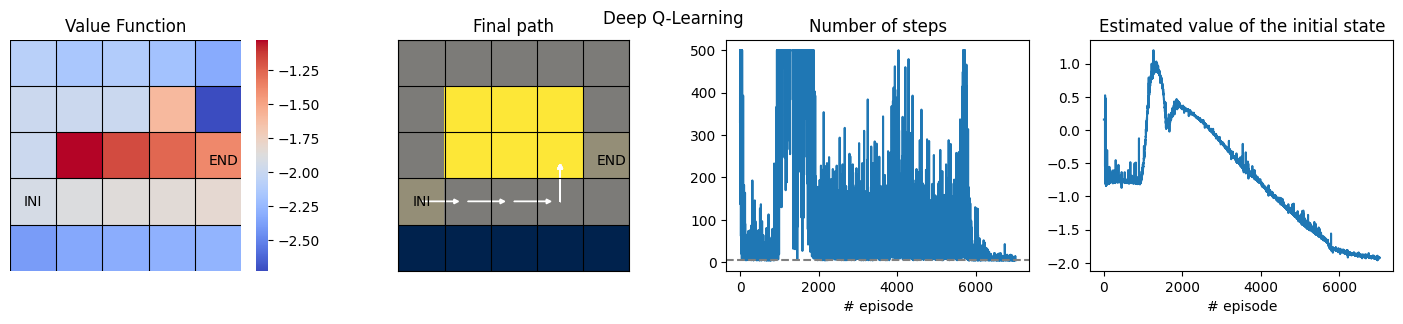

In [ ]:
rl_algs_names = [('Deep Q-Learning')]

fig, ax = plt.subplots(1, 4, figsize=(18, 3))
fig.suptitle(rl_algs_names[0])

vf_plot(results[0][0].reshape(env.n_cols, env.n_rows).transpose(), env, ax[0])
pol_plot(results[0][1], env, ax[1])
steps_plot(results[0][2], env, ax[2], shortest_path_length)
Q0_plot(results[0][3], env, ax[3])

## Learning curves

In [ ]:
def moving_average(a, n=3):
  ret = np.cumsum(a, dtype=float)
  ret[n:] = ret[n:] - ret[:-n]
  return ret[n - 1:] / n

In [ ]:
def loss_plot(data, smooth=True, name=None):
  with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(data)
    if smooth:
      data_smooth = moving_average(data, 50)
      ax.plot(data_smooth)


    if name is not None:
      ax.set_title(name)
    ax.set_xlabel('Step')
    ax.set_ylabel('Training loss')
    ax.grid(True, which='both', linestyle='--')

    if smooth:
      ax.plot(data, label='Raw values')
      ax.plot(data_smooth, label='Moving average')
      ax.legend(loc='upper right')

    plt.show()

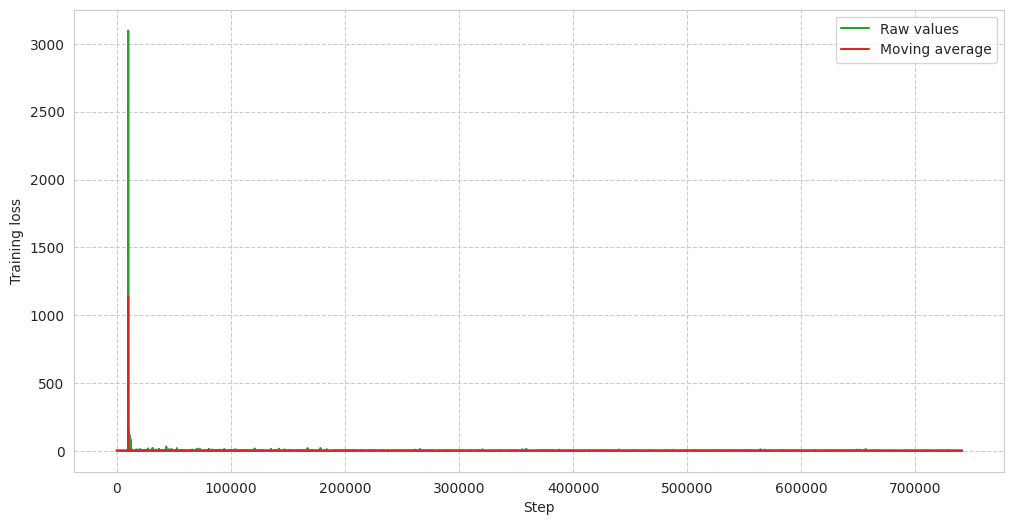

In [ ]:
loss_plot(results[0][4]) # Note that it will be 0 before the buffer is full and the agent starts updating

# Report

## Question 1
**Look at the code in detail and identify the parts where the behavioral or policy NN and the target NN are created. Run the code and observe the results obtained. Change the number of hidden layers and number of neurons of the critic and comment results.**

    # Here we define the structure of our network (target will be the same)
    # The input is the state descriptor: (Y,X) coordinates
    # The output is the value for every of the 4 actions
    def make_network(self, in_size, out_size):
      network = nn.Sequential(
        nn.Linear(in_size, 64),
        nn.ReLU(),
        nn.Linear(64, 16),
        nn.ReLU(),
        nn.Linear(16, out_size)
      )
      return network

The number of hidden layers is two, and the number of neurons in each layer are 64 for the first hidden layer, 16 for the second hidden layer, and the output layer has neurons equal to the number of actions in the environment

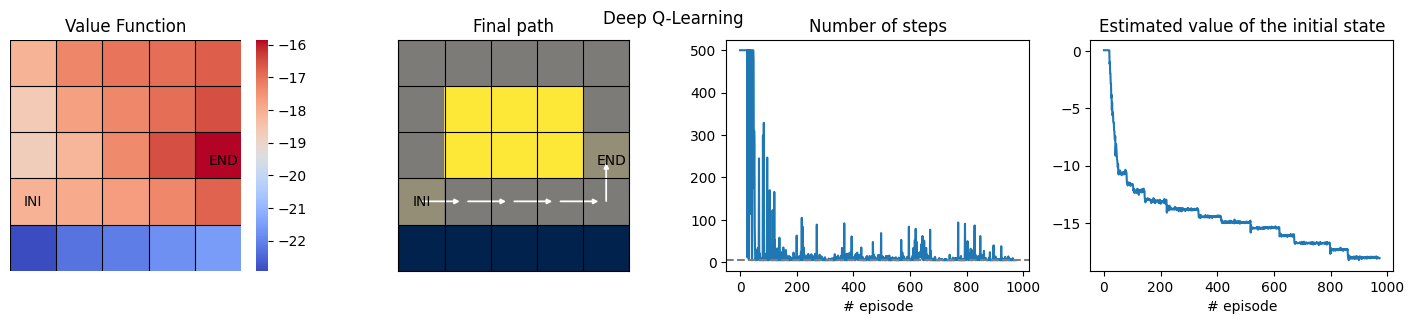

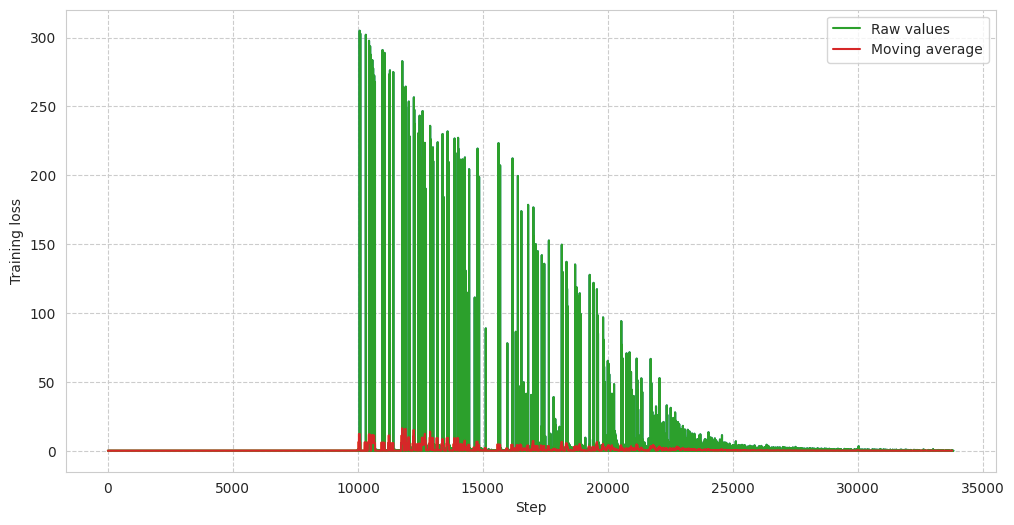

 I've increased the number of neurons in each layer and added an extra hidden layer:

    # Here we define the structure of our network (target will be the same)
    # The input is the state descriptor: (Y,X) coordinates
    # The output is the value for every of the 4 actions
    def make_network(self, in_size, out_size):
      network = nn.Sequential(
        network = nn.Sequential(
          nn.Linear(in_size, 128),  # Increased neurons in the first hidden layer to 128
          nn.ReLU(),
          nn.Linear(128, 64),        # Added extra hidden layer with 64 neurons
          nn.ReLU(),
          nn.Linear(64, 32),         # Added another hidden layer with 32 neurons
          nn.ReLU(),
          nn.Linear(32, out_size)
      )
      return network

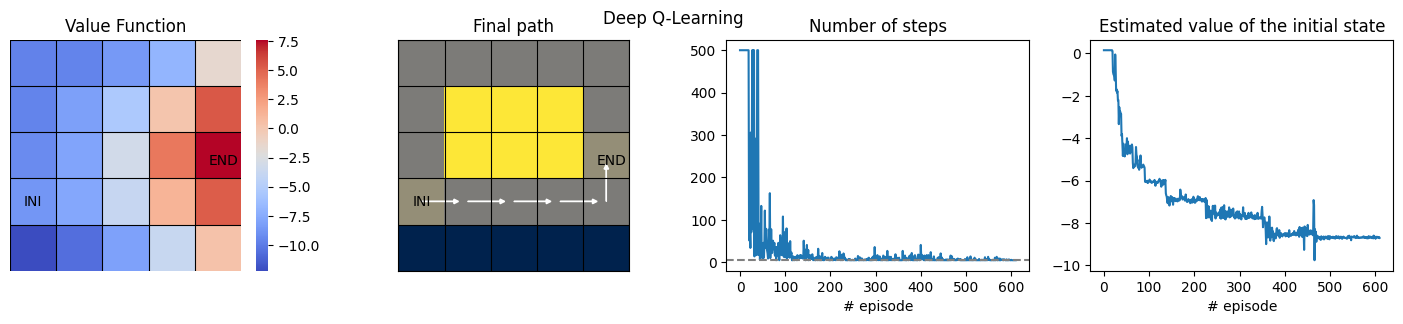

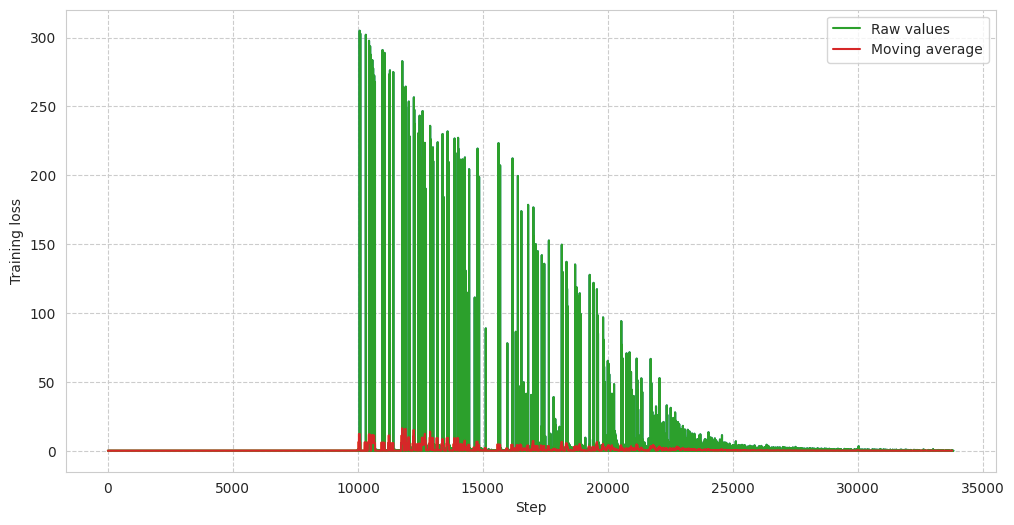

## Question 2
**The current method of updating the target network weights is the periodic one. Configure the smoothing method instead.**

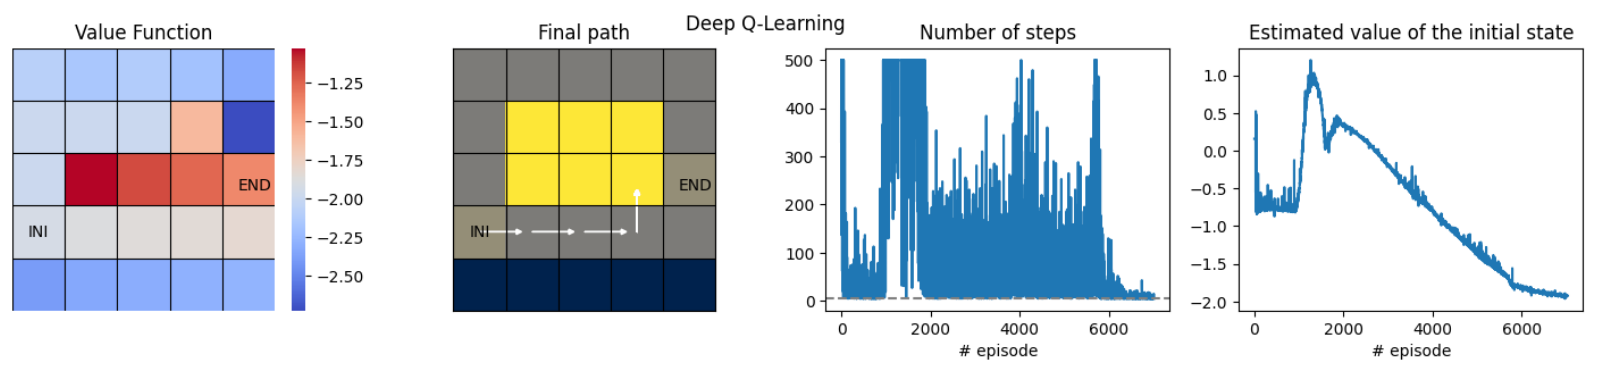

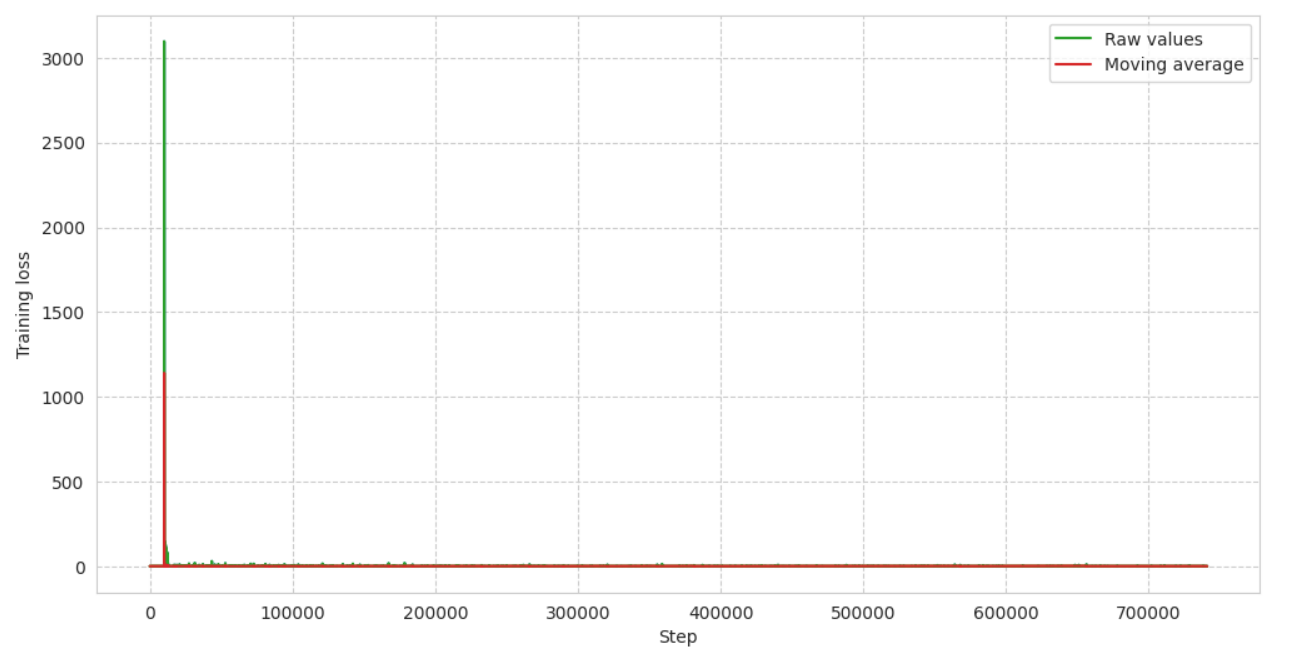